In [1]:
"""
Created on Wed Jan 20 14:52:04 2021

@author: Katrine O. Bangsgaard, Technical University of Denmark
"""
import numpy as np
import matplotlib.pyplot as plt
import egrss 
from scipy.stats import invgamma
from convergence_test import Geweke
# LaTeX font for figures
#plt.rc('font', family='DejaVu Sans', serif='Computer Modern Roman')
#plt.rc('text', usetex=True)


In [2]:
def plims(x,p = None):
    # computes the emperical quantiles 
    # m is number of samples
    # n is number of parameters
    
    m,n = x.shape
    
    if p is None: 
        p = np.array([0.025, 0.975])
    k, = p.shape
    y = np.zeros((k,n))
    for i in range(n):
        y[:,i] = np.interp((m-1)*p,range(m),np.sort(x[:,i])) 
    
    return y

## Problem formulation

Consider the observation model 
$$
\hat{y} = \Sigma \alpha + F \beta + e,
$$
where $\hat{y}\in R^n$, $\alpha\in R^n$ $\beta\in R^s$ and $\varepsilon \sim N(0, \delta I_{n})$. Hence the likelihood is given by,
$$
    \hat{y} \sim N(\Sigma \alpha + F \beta,\delta I_n).
$$
The likelihood function is defined
$$
L(y|v,u, \delta) \propto {\delta}^{-n/2} \exp\left(-\frac{1}{2\delta}\|\hat{y}-\Sigma \alpha - F \beta\|^2\right)
$$
We assume $\alpha$ is distributed as $\alpha \sim N(0,\tau \Sigma^{-1})$ and $\beta$ has the prior distribution $\beta \sim N(0,\gamma I)$
## Bayesian Approach and Smoothnes Priors
We aim to use a Baysian framework to compute samples from the joint posterior of $\alpha$, $\beta$, $\delta$, $\tau$ and $\gamma$ and thereby incorporate the uncertainty of the parameters and hyperparameters into the results. For simplicity we assume the hyperparameters are distributed according to the Inverse Gamma distribution due to its conjugacy relation to the mulitvariate Gaussian. In particular, we consider
$$
{\delta} \sim \text{InvGamma}(a_0,b_0), \quad {\tau} \sim \text{InvGamma}(a_1,b_1) \quad \text{and} \quad  {\gamma} \sim \text{InvGamma}(a_2,b_2)
$$
where we choose $a_0,a_1,a_2 = 1$ and  $b_0,b_1,b_2 = 10^{-4}$. The pdf of the hyper priors are
\begin{align}
\pi(\delta) &= \delta^{-a_0-1}\exp\left( -\frac{1}{\delta} b_0\right)\\
\pi(\tau) &= \tau^{-a_1-1}\exp\left( -\frac{1}{\tau} b_1\right)\\
\pi(\gamma) &= \gamma^{-a_2-1}\exp\left( -\frac{1}{\gamma} b_2\right)\\
\end{align}

## Full Posterior
We can now formulate the full posterior,
\begin{align}
\pi(\alpha,\beta,\delta,\tau,\gamma|\hat{y}) &\propto L(\hat{y}|\alpha,\beta,\delta) \pi(\alpha|\tau) \pi(\beta|\gamma)  \pi(\delta)\pi(\tau)\pi(\gamma)\\
\pi(\alpha,\beta,\delta,\tau,\gamma|\hat{y})  &\propto \delta^{-n/2}{\tau}^{-n/2}{\gamma}^{-s/2}\exp\left(-\frac{1}{2\delta}\|\hat{y}- \Sigma \alpha - F \beta\|^2-\frac{1}{2\tau}\alpha^T\Sigma\alpha-\frac{1}{2\gamma}\beta^T\beta\right)
 \delta^{(-a_0-1)} \tau^{(-a_1-1)}\gamma^{(-a_2-1)}
 \exp(-b_0\delta-b_1\tau-b_2\gamma) 
\end{align}
We cannot sample from the full posterior directly, but we can express the full conditional posteriors and use an Gibbsian approach to approximate samples from the full posterior. 

## Posterior for $\alpha$
The posterior for $\alpha$ is given by
$$
\pi(\alpha|\hat{y},\delta,\tau) \propto  L(\hat{y}|\alpha,\beta,\delta) \pi(\alpha|\tau)
$$
$$
\pi(\alpha|\hat{y},\delta,\tau) \propto\exp\left(-\frac{1}{2\delta}\|\hat{y}- \Sigma \alpha - F \beta\|^2- \frac{1}{2\tau} \alpha^T \Sigma \alpha\right)
$$
which is equivalent to 
$$
\alpha|y,\hat{y},\delta,\tau \sim N((\delta^{-1} \Sigma\Sigma+ \tau^{-1}\Sigma)^{-1}\delta^{-1}\Sigma \hat{y},(\delta^{-1} \Sigma\Sigma+ \tau^{-1} \Sigma)^{-1})
$$

## Posterior for $\beta$
The posterior for $\beta$ is given by
$$
\pi(\beta|\hat{y},\delta,\gamma) \propto  L(\hat{y}|\alpha,\beta,\delta) \pi(\beta|\gamma)
$$
$$
\pi(\beta|\hat{y},\delta,\gamma) \propto \exp\left(-\frac{1}{2\delta}\|\hat{y}- \Sigma \alpha - F \beta\|^2 - \frac{1}{2\gamma} \beta^T \beta \right)
$$
which is equivalent to 
$$
\beta|\hat{y},\delta,\gamma \sim N((\delta^{-1} F^TF+ \gamma^{-1}I)^{-1}\delta^{-1}F^T \hat{y},(\delta^{-1} F^TF+ \gamma^{-1} I)^{-1})
$$

## Posterior for the Hyperparameters
The posterior for $\delta$ $\tau$ and $\gamma$ are

$$
 \pi(\delta|\hat{y},\alpha,\beta) \propto L(\hat{y}|\alpha,\beta,\delta)\pi(\delta)
$$
$$
 \pi(\delta|\hat{y},\alpha,\beta)\propto
  \delta^{\left(-a_0-\frac{n}{2}-1\right)} \exp\left(-{\delta}^{-1}\left(\frac{1}{2\delta}\|\hat{y}- \Sigma \alpha - F \beta\|^2+b_0\right)\right) 
 $$
 which is a Gamma distribution with parameters $\delta \sim \text{InvGamma} ( a_0+ n/2, b_0 + \frac{1}{2}\|\hat{y}- \Sigma \alpha - F \beta\|^2)$.
 
The posterior of $\tau$ is 
 $$
\pi(\tau|\alpha)\propto
  \tau^{\left(-a_1-\frac{n}{2}-1\right)} \exp\left(-{\tau}^{-1}\left(\alpha^T \Sigma \alpha+b_1\right)\right) 
 $$
 Computing the posterior for $\gamma$ 
$$
 \pi(\gamma|\beta)  \propto \pi(\beta|\gamma) \pi(\gamma) =
  \gamma^{\left(-a_2-\frac{K}{2}-1\right)}   \exp\left(-{\gamma}^{-1}( \beta^T \beta +b_2)\right) 
$$

## The Gibbs sampler

The Gibbs sampler is 2-stage. First we sample the hyperparameters and then the parameters, i.e.,

1) Sample from the posterior for $\delta$, $\tau$ and $\gamma$

2) Sample form the posterior for $z$ and $\beta$ 

## Generate data 

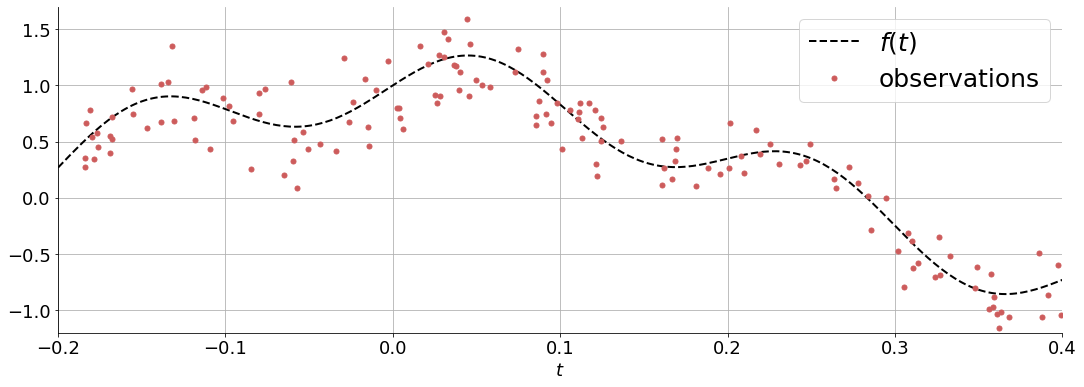

In [3]:
# Generate data  
n    = 150
delt = 1 / (0.2 ** 2)
a,b  = -0.2, 0.4

t = a + np.sort(np.random.uniform(low = 1e-13, high = 1, size = (n,)),axis =0) *(b-a)

# Function 
def f(t):
    return np.cos(2*np.pi *t) + 0.3 * np.sin(10* np.pi *t) + 0.2 * t

# Generate data with noise level sigma
yhat = f(t) + 1 / np.sqrt(delt) * np.random.normal(loc = 0, scale = 1, size = t.shape)


# Plot of the true function and data 
tt = np.linspace(a,b,300)

plt.figure(figsize=(18,6))
plt.plot(tt,f(tt),'--',color = 'black',label = '$f(t)$',linewidth= 2)
plt.plot(t,yhat,'o',color = 'indianred',markersize = 5,label = 'observations')
plt.xlim((-0.2,0.4))
plt.xlabel('$t$',fontsize = 18)
plt.ylim((-1.2,1.7))
plt.legend(loc = 'best',fontsize = 25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()

#plt.savefig('smoothingdata.eps', format='eps')

## Efficient computation of Posterior for $\alpha$ and $\beta$ with perturbation
We can obtain samples by solving the following system of equations,
\begin{align*}
  (\delta^{-1} \Sigma\Sigma + \tau^{-1} \Sigma)\alpha = \delta^{-1}  \Sigma \left(\hat{y}- F \beta\right) + \sqrt{\delta} \Sigma \xi_y + \sqrt{\tau} \tilde{L} \xi_{\alpha}, \\
\end{align*}
where $\xi_y , \xi_x \sim N(0,I_n)$ and $\tilde{L}\tilde{L}^T= \Sigma$.
To avoid multiplying $\xi_{\alpha}$ with $\tilde{L}^{-T}$ we introduce a change of variables, i.e., $z = \Sigma \alpha$. We can then write our system of equations asn, 
\begin{align*}
 ( \Sigma + \frac{\delta}{\tau} I)\Sigma \alpha &= \Sigma \left(\hat{y}- F \beta +\frac{\delta}{\sqrt{\delta}}\xi_y\right) + \frac{\delta}{\sqrt{\tau}} \tilde{L} \xi_{\alpha},\\
  ( \Sigma + \frac{\delta}{\tau} I)z &= \Sigma \left(\hat{y}- F \beta +\frac{\delta}{\sqrt{\delta}}\xi_y\right) + \frac{\delta}{\sqrt{\tau}} \tilde{L} \xi_{\alpha},
\end{align*}
We can then introduce $LL^T = \Sigma + \frac{\delta}{\tau} I $. We can then efficiently draw samples from the posterior of $z$ by solving the following
\begin{align}
LL^T z &=    \Sigma \left(\hat{y}- F \beta +\frac{\delta}{\sqrt{\delta}}\xi_y\right) + \frac{\delta}{\sqrt{\tau}} \tilde{L} \xi_{\alpha}.
\end{align}
Note that we can express the posterior of $\tau$ in terms of $z$ by,
$$
\pi(\tau|z)\propto
  \tau^{\left(-a_1-\frac{n}{2}-1\right)} \exp\left(-{\tau}^{-1}\left(z^T \Sigma^{-1} z+b_1\right)\right) 
 $$

We can obtain samples for $\beta$ by solving an instance of 
\begin{align*}
  (\delta^{-1} F^TF + \gamma^{-1} I)\beta = \delta^{-1} F^T (\hat{y}-z) + \frac{1}{\sqrt{\delta}} F^T \xi_y + \frac{1}{\sqrt{\gamma}}\xi_{\beta}, \\
    ( F^TF + \delta\gamma^{-1} I)\beta = F^T (\hat{y}-z) + \frac{\delta}{\sqrt{\delta}} F^T \xi_y + \frac{\delta}{\sqrt{\gamma}}\xi_{\beta},
\end{align*}
where $\xi_y\sim N(0,I_n)$ and $\xi_{\beta} \sim N(0,I_s)$.
Here the left hand side matrix is an s times s matrix and thus computational inexpensive to form. Thus we simply form the matrix and solve the system of equations. 


## Stability for $\gamma$
It seems that the sampler is more robust when replacing $gamma$ with $1 / \gamma$ and assuming Gamma prior instead of InverseGamma. Hence this modification has been applied to the code but theoretically both formulations are equivalent.  

In [4]:
### Gibbs sampler - we aim to sample from the joint posterior pi(v,u,sigma,lambda,delta|y) 
# See posteriors derived in overleaf
nsamps = 10000
s      = 2

# Initialization and memory allocation
del_samp   = np.zeros(nsamps)
tau_samp   = np.zeros(nsamps)
gam_samp   = np.zeros(nsamps)
z_samp     = np.zeros((n,nsamps))
bet_samp   = np.zeros((s,nsamps))
y_samp     = np.zeros((n,nsamps))

# pre-compute matrices and matrix-vector products
Ft, Vt = egrss.generators((t-a)/(b-a),s)       
Wt,eps   = egrss.potrf(Ft,Vt,1e-10) # regularizes the factorization

# initializations
Fb       = Ft.T @ bet_samp[:,0]
residual = np.zeros((n,))

In [5]:
for i in range(nsamps-1):      
    # sample hyperparameters lambda and nu (delta and alpha)
    # (1a) sample delta    
    a0,b0         = 1.0 + n / 2, 1e-4 + 0.5 * (residual.T @ residual)
    del_samp[i+1] =  1 / np.random.gamma(shape=a0, scale=1/b0)

    # (1b) sample tau
    tmp           = egrss.trsv(Ft,Wt,z_samp[:,i],eps,'N')
    a1,b1         = 1.0 + n / 2, 1e-4+ 0.5 * (tmp.T @ tmp)
    tau_samp[i+1] = 1/ np.random.gamma(shape=a1, scale=1/b1)

    # (1c) sample gamma
    a2,b2    = 1.0 + s / 2, 1e-4+ 0.5 * (bet_samp[:,i].T @ bet_samp[:,i])
    gam_samp[i+1] =  np.random.gamma(shape=a2, scale=1/b2)
    
    # 2) Compute posterior for z and beta 
    # 2a) Compute posterior for z
    xiy   = np.random.normal(loc=0, scale=1, size= n)
    xia   = np.random.normal(loc=0, scale=1, size= n)
    d     = del_samp[i+1] / tau_samp[i+1]
    Zt,c  = egrss.potrf(Ft,Vt,d)
    rhs   = egrss.symv(Ft,Vt,yhat - Fb + del_samp[i+1]  / np.sqrt(del_samp[i+1]) *  xiy) + del_samp[i+1]  / np.sqrt(tau_samp[i+1]) * egrss.trmv(Ft, Wt, xia,eps,'N')
    Lrhs  = egrss.trsv(Ft,Zt,rhs,c,'N')
    z_samp[:,i+1] = egrss.trsv(Ft,Zt,Lrhs,c,'T')
   
    
    # 2b) Compute posterior for beta
    xib = np.random.normal(loc=0, scale=1, size= s)
    rhs = Ft @(yhat-z_samp[:,i+1]+ del_samp[i+1]  / np.sqrt(del_samp[i+1]) * xiy) + del_samp[i+1]  * np.sqrt(gam_samp[i+1]) * xib
    d   = del_samp[i+1] * gam_samp[i+1]
    M   = Ft @Ft.T + d * np.eye(s)
    bet_samp[:,i+1] = np.linalg.solve(M,rhs)
    
    # update y
    Fb            = Ft.T @ bet_samp[:,i+1]
    y_samp[:,i+1] = z_samp[:,i+1] + Fb
    
    # update residual
    residual      = yhat- y_samp[:,i+1]
    
    

In [16]:
## Sample statistics 
# Remove burn-in phase 
burnin   = int(del_samp.size/2) 
nmax     = nsamps #burnin+2000
z_res    = z_samp[:,burnin:nmax]
bet_res  = bet_samp[:,burnin:nmax]
y_res    = y_samp[:,burnin:nmax]

del_res = del_samp[burnin:nmax]
tau_res = tau_samp[burnin:nmax]
gam_res = gam_samp[burnin:nmax]
# Reshape results for statistical functions 
del_res.shape=(nmax-burnin,1)
tau_res.shape=(nmax-burnin,1)
gam_res.shape=(nmax-burnin,1)

# Compute posterior mean 
del_mean = np.mean(del_res,0)
tau_mean = np.mean(tau_res,0)
gam_mean = np.mean(gam_res,0)
z_mean   = np.mean(z_res,1)
bet_mean = np.mean(bet_res,1)
y_mean   = np.mean(y_res,1)

# Compute 95% CI 
del_ci  = plims(del_res)
tau_ci  = plims(tau_res)
gam_ci  = plims(gam_res)
y_ci    = plims(y_res.T)

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <a list of 8 Text major ticklabel objects>)

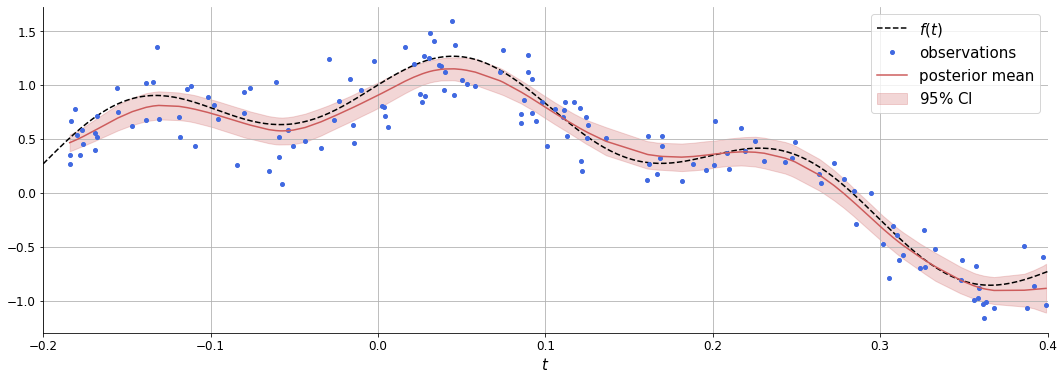

In [17]:
plt.figure(figsize=(18,6))
plt.plot(tt,f(tt),'--',color = 'black',label = '$f(t)$')
plt.plot(t,yhat,'o',color = 'royalblue',markersize = 4,label = 'observations')
plt.plot(t,y_mean,color = 'indianred',label='posterior mean')
plt.fill_between(t,y_ci[0,:],y_ci[1,:], color='indianred', alpha=.25,label = '$95\%$ CI')

plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlim((-0.2,0.4))
plt.xlabel('$t$',fontsize = 15)
plt.legend(loc = 'best',fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig('test4x.png', format='png')

/Users/KatBang/Desktop/smoothingspline/convergence_test.py:79: RuntimeWarning: divide by zero encountered in true_divide
  f    = 1/(n*idx2)


[0.99419011 0.98578212 0.99200116]


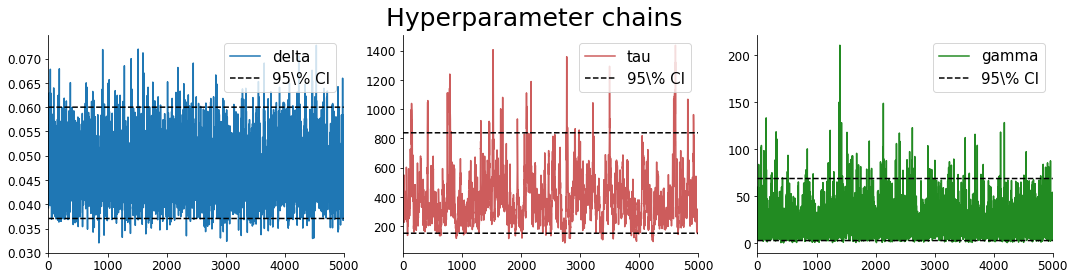

In [18]:
## plot hyperparameter chains to asses convergence of the sampler, 
# if the mean is stationary then it is an good indication that the sampler has converged

fig,ax = plt.subplots(1,3,figsize=(18, 4))
fig.suptitle('Hyperparameter chains',fontsize = 25)
ax[0].plot(del_res,label ='delta')
ax[0].set_xlim((0,nmax-burnin))
ax[1].plot(tau_res,label ='tau',color = 'indianred')
ax[1].set_xlim((0,nmax-burnin))
ax[2].plot(gam_res,label ='gamma',color = 'forestgreen')
ax[2].set_xlim((0,nmax-burnin))
# 95% CI
ax[0].plot(del_ci[0]*np.ones(nsamps-burnin),'--',color='black',label ='95\% CI')
ax[0].plot(del_ci[1]*np.ones(nsamps-burnin),'--',color='black')

ax[1].plot(tau_ci[0]*np.ones(nsamps-burnin),'--',color='black',label ='95\% CI')
ax[1].plot(tau_ci[1]*np.ones(nsamps-burnin),'--',color='black')

ax[2].plot(gam_ci[0]*np.ones(nsamps-burnin),'--',color='black',label ='95\% CI')
ax[2].plot(gam_ci[1]*np.ones(nsamps-burnin),'--',color='black')

# set legends
ax[0].legend(loc = 'upper right',fontsize = 15)
ax[1].legend(loc = 'upper right',fontsize = 15)
ax[2].legend(loc = 'upper right',fontsize = 15)
# remove box
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
# change fontsize of ticks
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)
ax[2].tick_params(axis='x', labelsize=12)
ax[2].tick_params(axis='y', labelsize=12)
#
# Compute Geweke p values
# To asses the convergence of our Gibbs sampler, we use the Geweke diagnostic as a quantitative measure
# The Geweke test compares the mean of two subset of samples (the first 10% of the chain and the last 50% of the chain)
# if p is close to 1 (rule of thumb: p > 0.95) then we conclude that the sampler has converged
#
# citation: 
# @MISC{Geweke92,
#    author = {John Geweke},
#    title = {Evaluating the Accuracy of Sampling-Based Approaches to the Calculation of Posterior Moments},
#    year = {1992}}

hyp_chain =  np.concatenate((del_res, tau_res,gam_res),axis= 1)
_,p       = Geweke(hyp_chain,0.1,0.5)
print(p)
#plt.savefig('test4hyp.png', format='png')